In [1]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from tensorboard import summary
from tensorflow.python.feature_column.feature_column import linear_model

# Create Batch1

In [2]:
mat_file_1 = '2017-05-12_batchdata_updated_struct_errorcorrect.mat'
f = h5py.File(mat_file_1, 'r')

In [3]:
f.keys()

<KeysViewHDF5 ['#refs#', '#subsystem#', 'batch', 'batch_date']>

In [4]:
batch = f['batch']
batch.keys()

<KeysViewHDF5 ['Vdlin', 'barcode', 'channel_id', 'cycle_life', 'cycles', 'policy', 'policy_readable', 'summary']>

In [5]:
batch_dat = f['batch_date']
#batch_dat.keys()
print(list(f.keys()))

['#refs#', '#subsystem#', 'batch', 'batch_date']


In [6]:
df = pd.DataFrame(batch.keys())
print(df)

                 0
0            Vdlin
1          barcode
2       channel_id
3       cycle_life
4           cycles
5           policy
6  policy_readable
7          summary


In [7]:
print("Keys under batch :", list(batch.keys()))

Keys under batch : ['Vdlin', 'barcode', 'channel_id', 'cycle_life', 'cycles', 'policy', 'policy_readable', 'summary']


In [8]:
f = h5py.File(mat_file_1, 'r')

batch = f['batch']

num_cells = batch['summary'].shape[0]
battery_dict_1 = {}  #  create empty_dictionary


for i in range(num_cells):                 # Loop Over Each Battery Cell
    cl = f[batch['cycle_life'][i, 0]][()].item()  # Extract key information
    policy = f[batch['policy_readable'][i, 0]][()].tobytes()[::2].decode()

    # Extract Summary Data
    summary_IR = np.hstack([f[batch['summary'][i, 0]]['IR'][0, :][()].flatten()])
    summary_QC = np.hstack([f[batch['summary'][i, 0]]['QCharge'][0, :][()].flatten()])
    summary_QD = np.hstack([f[batch['summary'][i, 0]]['QDischarge'][0, :][()].flatten()])
    summary_TA = np.hstack([f[batch['summary'][i, 0]]['Tavg'][0, :][()].flatten()])
    summary_TM = np.hstack([f[batch['summary'][i, 0]]['Tmin'][0, :][()].flatten()])
    summary_TX = np.hstack([f[batch['summary'][i, 0]]['Tmax'][0, :][()].flatten()])
    summary_CT = np.hstack([f[batch['summary'][i, 0]]['chargetime'][0, :][()].flatten()])
    summary_CY = np.hstack([f[batch['summary'][i, 0]]['cycle'][0, :][()].flatten()])
    summary = {
        'IR': summary_IR, 'QC': summary_QC, 'QD': summary_QD,
        'Tavg': summary_TA, 'Tmin': summary_TM, 'Tmax': summary_TX,
        'chargetime': summary_CT, 'cycle': summary_CY
    }

    # Extract Detailed Cycle Data
    cycles = f[batch['cycles'][i, 0]]
    cycle_dict = {}

    for j in range(cycles['I'].shape[0]):
        I = f[cycles['I'][j, 0]][()].flatten()
        Qc = f[cycles['Qc'][j, 0]][()].flatten()
        Qd = f[cycles['Qd'][j, 0]][()].flatten()
        Qdlin = f[cycles['Qdlin'][j, 0]][()].flatten()
        T = f[cycles['T'][j, 0]][()].flatten()
        Tdlin = f[cycles['Tdlin'][j, 0]][()].flatten()
        V = f[cycles['V'][j, 0]][()].flatten()
        dQdV = f[cycles['discharge_dQdV'][j, 0]][()].flatten()
        t = f[cycles['t'][j, 0]][()].flatten()
        cd = {
            'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin,
            'T': T, 'Tdlin': Tdlin, 'V': V, 'dQdV': dQdV, 't': t
        }
        cycle_dict[str(j)] = cd

# Combine Cell Data
    cell_dict = {
        'cycle_life': cl,
        'charge_policy': policy,
        'summary': summary,
        'cycles': cycle_dict
    }
    key = 'b1c' + str(i)
    battery_dict_1[key] = cell_dict


In [9]:
sum=print((list(summary)))

['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle']


In [10]:
battery_dict_1.keys()

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c8', 'b1c9', 'b1c10', 'b1c11', 'b1c12', 'b1c13', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c22', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45'])

* Define parse_policy() Function

* Extracts the numerical values from charging policy strings like:
  "4C(60%)-2C" → C1=4.0, Q1=60.0, C2=2.0
  * ([0-9.]+) → captures first charge rate (e.g., 4 or 1.5)
  * \((\d+)%\) → captures percentage (e.g., 60)
  * -([0-9.]+)C → captures second charge rate (e.g., 2)
    If the format doesn’t match, it safely returns (None, None, None).

* Loop Over Each Battery Cell
* Convert Each Summary to a DataFrame
* Store Back into the Dictionary
  battery_dict_1[battery_id]['summary_df'] = df
* Combine All Battery Data

In [11]:
import re


def parse_policy(policy_str):
    " Extracts  4C(60%)-2C "
    try:
        match = re.match(r"([0-9.]+)C\((\d+)%\)-([0-9.]+)C", policy_str)
        if match:
            c1, q1, c2 = map(float, match.groups())
            return c1, q1, c2
    except:
        pass
    return None, None, None


for battery_id, cell in battery_dict_1.items():
    policy_str = cell['charge_policy'] if isinstance(cell['charge_policy'], str) else ""
    c1, q1, c2 = parse_policy(policy_str)
    df = pd.DataFrame(cell['summary'])
    df['battery_id'] = battery_id
    df['cycle_life'] = cell['cycle_life']
    df['C1'] = c1
    df['Q1'] = q1
    df['C2'] = c2
    battery_dict_1[battery_id]['summary_df'] = df

all_dfs = [cell['summary_df'] for cell in battery_dict_1.values()]
Bt_1 = pd.concat(all_dfs, ignore_index=True)
Bt_1.shape

(38811, 13)

In [12]:
Bt_1

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,b1c0,1190.0,3.6,80.0,3.6
1,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250,2.0,b1c0,1190.0,3.6,80.0,3.6
2,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777,3.0,b1c0,1190.0,3.6,80.0,3.6
3,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167,4.0,b1c0,1190.0,3.6,80.0,3.6
4,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442,5.0,b1c0,1190.0,3.6,80.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38806,0.020337,0.887369,0.885883,33.709809,30.059217,38.676792,19.923232,594.0,b1c45,599.0,8.0,35.0,3.6
38807,0.020473,0.885484,0.884301,33.727794,30.237862,38.678028,20.731932,595.0,b1c45,599.0,8.0,35.0,3.6
38808,0.020493,0.884648,0.883173,33.630904,30.104025,38.663055,22.061037,596.0,b1c45,599.0,8.0,35.0,3.6
38809,0.020503,0.883895,0.882425,33.715893,30.051764,38.717087,22.810185,597.0,b1c45,599.0,8.0,35.0,3.6


* in hear create the per cell 50 cycle data

In [13]:
summary_first_50_data_1 = Bt_1.groupby('battery_id').head(50).reset_index(drop=True)

print("Shape_summary_first_50_data:", summary_first_50_data_1.shape)
fst_50_cy_dt_1 = summary_first_50_data_1.copy()
print("fst_50_cy_dt_1:", fst_50_cy_dt_1.shape)

Shape_summary_first_50_data: (2300, 13)
fst_50_cy_dt_1: (2300, 13)


In [14]:
fst_50_cy_dt_1

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,b1c0,1190.0,3.6,80.0,3.6
1,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250,2.0,b1c0,1190.0,3.6,80.0,3.6
2,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777,3.0,b1c0,1190.0,3.6,80.0,3.6
3,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167,4.0,b1c0,1190.0,3.6,80.0,3.6
4,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442,5.0,b1c0,1190.0,3.6,80.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,0.016683,1.087311,1.087584,32.831865,29.864557,36.536152,10.220962,46.0,b1c45,599.0,8.0,35.0,3.6
2296,0.016668,1.087259,1.087567,32.868466,29.732851,36.546894,10.304470,47.0,b1c45,599.0,8.0,35.0,3.6
2297,0.016663,1.087236,1.087492,32.828632,29.857639,36.498089,10.220978,48.0,b1c45,599.0,8.0,35.0,3.6
2298,0.016675,1.087248,1.087526,32.865756,29.840807,36.602509,10.221937,49.0,b1c45,599.0,8.0,35.0,3.6


# Batch2

In [15]:
mat_file_2 = '2017-06-30_batchdata_updated_struct_errorcorrect.mat'
f = h5py.File(mat_file_2)
batch = f['batch']

In [16]:
import pandas as pd

df = pd.DataFrame(batch.keys())
print(df)

                 0
0            Vdlin
1          barcode
2       channel_id
3       cycle_life
4           cycles
5           policy
6  policy_readable
7          summary


In [17]:
num_cells = batch['summary'].shape[0]
battery_dict_2 = {}

for i in range(num_cells):
    cl = f[batch['cycle_life'][i, 0]][()].item()
    policy = f[batch['policy_readable'][i, 0]][()].tobytes()[::2].decode()
    summary_IR = np.hstack([f[batch['summary'][i, 0]]['IR'][0, :][()].flatten()])
    summary_QC = np.hstack([f[batch['summary'][i, 0]]['QCharge'][0, :][()].flatten()])
    summary_QD = np.hstack([f[batch['summary'][i, 0]]['QDischarge'][0, :][()].flatten()])
    summary_TA = np.hstack([f[batch['summary'][i, 0]]['Tavg'][0, :][()].flatten()])
    summary_TM = np.hstack([f[batch['summary'][i, 0]]['Tmin'][0, :][()].flatten()])
    summary_TX = np.hstack([f[batch['summary'][i, 0]]['Tmax'][0, :][()].flatten()])
    summary_CT = np.hstack([f[batch['summary'][i, 0]]['chargetime'][0, :][()].flatten()])
    summary_CY = np.hstack([f[batch['summary'][i, 0]]['cycle'][0, :][()].flatten()])
    summary = {
        'IR': summary_IR, 'QC': summary_QC, 'QD': summary_QD,
        'Tavg': summary_TA, 'Tmin': summary_TM, 'Tmax': summary_TX,
        'chargetime': summary_CT, 'cycle': summary_CY
    }
    cycles = f[batch['cycles'][i, 0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = f[cycles['I'][j, 0]][()].flatten()
        Qc = f[cycles['Qc'][j, 0]][()].flatten()
        Qd = f[cycles['Qd'][j, 0]][()].flatten()
        Qdlin = f[cycles['Qdlin'][j, 0]][()].flatten()
        T = f[cycles['T'][j, 0]][()].flatten()
        Tdlin = f[cycles['Tdlin'][j, 0]][()].flatten()
        V = f[cycles['V'][j, 0]][()].flatten()
        dQdV = f[cycles['discharge_dQdV'][j, 0]][()].flatten()
        t = f[cycles['t'][j, 0]][()].flatten()
        cd = {
            'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin,
            'T': T, 'Tdlin': Tdlin, 'V': V, 'dQdV': dQdV, 't': t
        }
        cycle_dict[str(j)] = cd

    cell_dict = {
        'cycle_life': cl,
        'charge_policy': policy,
        'summary': summary,
        'cycles': cycle_dict
    }
    key = 'b2c' + str(i)
    battery_dict_2[key] = cell_dict

In [18]:
battery_dict_2.keys()

dict_keys(['b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c7', 'b2c8', 'b2c9', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c15', 'b2c16', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47'])

In [19]:
import pandas as pd
import re


def parse_policy(policy_str):
    " Extracts  4C(60%)-2C "
    try:
        match = re.match(r"([0-9.]+)C\((\d+)%\)-([0-9.]+)C", policy_str)
        if match:
            c1, q1, c2 = map(float, match.groups())
            return c1, q1, c2
    except:
        pass
    return None, None, None


for battery_id, cell in battery_dict_2.items():
    policy_str = cell['charge_policy'] if isinstance(cell['charge_policy'], str) else ""
    c1, q1, c2 = parse_policy(policy_str)
    df = pd.DataFrame(cell['summary'])
    df['battery_id'] = battery_id
    df['cycle_life'] = cell['cycle_life']
    df['C1'] = c1
    df['Q1'] = q1
    df['C2'] = c2
    battery_dict_2[battery_id]['summary_df'] = df

all_dfs = [cell['summary_df'] for cell in battery_dict_2.values()]
summary_combined_2 = pd.concat(all_dfs, ignore_index=True)
summary_combined_2.shape

C:\Users\ROHIT\AppData\Local\Temp\ipykernel_9708\3974942936.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_combined_2 = pd.concat(all_dfs, ignore_index=True)


(24920, 13)

In [20]:
summary_combined_2

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.017542,1.067561,1.068057,30.363545,28.999689,31.487127,10.332668,1.0,b2c0,300.0,1.0,4.0,6.0
1,0.017505,1.069810,1.070054,29.160560,26.734909,31.661930,10.180050,2.0,b2c0,300.0,1.0,4.0,6.0
2,0.017571,1.071287,1.071910,29.711384,28.086988,31.111683,10.308322,3.0,b2c0,300.0,1.0,4.0,6.0
3,0.017263,1.072626,1.072965,30.235232,28.464998,31.539034,10.276183,4.0,b2c0,300.0,1.0,4.0,6.0
4,0.017489,1.071483,1.071910,29.481769,27.695206,31.414228,10.263642,5.0,b2c0,300.0,1.0,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24915,0.020284,0.836581,0.834485,33.351623,29.902174,38.214260,20.000000,741.0,b2c47,713.0,6.0,60.0,3.0
24916,0.020283,0.834719,0.832141,33.224035,29.923616,38.253880,20.000000,742.0,b2c47,713.0,6.0,60.0,3.0
24917,0.020371,0.832569,0.830499,33.282337,29.813374,38.336826,20.000000,743.0,b2c47,713.0,6.0,60.0,3.0
24918,0.020406,0.830548,0.828347,33.373176,29.784494,38.279568,20.000000,744.0,b2c47,713.0,6.0,60.0,3.0


In [21]:
summary_first_50_data_2 = summary_combined_2.groupby('battery_id').head(50).reset_index(drop=True)

print("Shape_summary_first_50_data:", summary_first_50_data_2.shape)
Batch2 = summary_first_50_data_2.copy()
print("Shape_Batch2:", Batch2.shape)

Shape_summary_first_50_data: (2400, 13)
Shape_Batch2: (2400, 13)


In [22]:
Batch2

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.017542,1.067561,1.068057,30.363545,28.999689,31.487127,10.332668,1.0,b2c0,300.0,1.0,4.0,6.0
1,0.017505,1.069810,1.070054,29.160560,26.734909,31.661930,10.180050,2.0,b2c0,300.0,1.0,4.0,6.0
2,0.017571,1.071287,1.071910,29.711384,28.086988,31.111683,10.308322,3.0,b2c0,300.0,1.0,4.0,6.0
3,0.017263,1.072626,1.072965,30.235232,28.464998,31.539034,10.276183,4.0,b2c0,300.0,1.0,4.0,6.0
4,0.017489,1.071483,1.071910,29.481769,27.695206,31.414228,10.263642,5.0,b2c0,300.0,1.0,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0.017171,1.049489,1.049833,32.497725,29.385515,36.459629,10.179140,46.0,b2c47,713.0,6.0,60.0,3.0
2396,0.017159,1.049492,1.049915,32.435424,29.585482,36.574768,10.179088,47.0,b2c47,713.0,6.0,60.0,3.0
2397,0.017161,1.049419,1.049806,32.397096,29.739912,36.586670,10.179405,48.0,b2c47,713.0,6.0,60.0,3.0
2398,0.017146,1.049345,1.049750,32.311683,29.463625,36.295872,10.096282,49.0,b2c47,713.0,6.0,60.0,3.0


# Create Batch3

In [23]:
mat_file_3 = '2018-04-12_batchdata_updated_struct_errorcorrect.mat'
f = h5py.File(mat_file_3)
batch = f['batch']

In [24]:
num_cells = batch['summary'].shape[0]
battery_dict_3 = {}

for i in range(num_cells):
    cl = f[batch['cycle_life'][i, 0]][()].item()
    policy = f[batch['policy_readable'][i, 0]][()].tobytes()[::2].decode()
    summary_IR = np.hstack([f[batch['summary'][i, 0]]['IR'][0, :][()].flatten()])
    summary_QC = np.hstack([f[batch['summary'][i, 0]]['QCharge'][0, :][()].flatten()])
    summary_QD = np.hstack([f[batch['summary'][i, 0]]['QDischarge'][0, :][()].flatten()])
    summary_TA = np.hstack([f[batch['summary'][i, 0]]['Tavg'][0, :][()].flatten()])
    summary_TM = np.hstack([f[batch['summary'][i, 0]]['Tmin'][0, :][()].flatten()])
    summary_TX = np.hstack([f[batch['summary'][i, 0]]['Tmax'][0, :][()].flatten()])
    summary_CT = np.hstack([f[batch['summary'][i, 0]]['chargetime'][0, :][()].flatten()])
    summary_CY = np.hstack([f[batch['summary'][i, 0]]['cycle'][0, :][()].flatten()])
    summary = {
        'IR': summary_IR, 'QC': summary_QC, 'QD': summary_QD,
        'Tavg': summary_TA, 'Tmin': summary_TM, 'Tmax': summary_TX,
        'chargetime': summary_CT, 'cycle': summary_CY
    }
    cycles = f[batch['cycles'][i, 0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = f[cycles['I'][j, 0]][()].flatten()
        Qc = f[cycles['Qc'][j, 0]][()].flatten()
        Qd = f[cycles['Qd'][j, 0]][()].flatten()
        Qdlin = f[cycles['Qdlin'][j, 0]][()].flatten()
        T = f[cycles['T'][j, 0]][()].flatten()
        Tdlin = f[cycles['Tdlin'][j, 0]][()].flatten()
        V = f[cycles['V'][j, 0]][()].flatten()
        dQdV = f[cycles['discharge_dQdV'][j, 0]][()].flatten()
        t = f[cycles['t'][j, 0]][()].flatten()
        cd = {
            'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin,
            'T': T, 'Tdlin': Tdlin, 'V': V, 'dQdV': dQdV, 't': t
        }
        cycle_dict[str(j)] = cd

    cell_dict = {
        'cycle_life': cl,
        'charge_policy': policy,
        'summary': summary,
        'cycles': cycle_dict
    }
    key = 'b3c' + str(i)
    battery_dict_3[key] = cell_dict

In [25]:
battery_dict_3.keys()

dict_keys(['b3c0', 'b3c1', 'b3c2', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b3c19', 'b3c20', 'b3c21', 'b3c22', 'b3c23', 'b3c24', 'b3c25', 'b3c26', 'b3c27', 'b3c28', 'b3c29', 'b3c30', 'b3c31', 'b3c32', 'b3c33', 'b3c34', 'b3c35', 'b3c36', 'b3c37', 'b3c38', 'b3c39', 'b3c40', 'b3c41', 'b3c42', 'b3c43', 'b3c44', 'b3c45'])

In [26]:
import pandas as pd
import re


def parse_policy(policy_str):
    " Extracts  4C(60%)-2C "
    try:
        match = re.match(r"([0-9.]+)C\((\d+)%\)-([0-9.]+)C", policy_str)
        if match:
            c1, q1, c2 = map(float, match.groups())
            return c1, q1, c2
    except:
        pass
    return None, None, None


for battery_id, cell in battery_dict_3.items():
    policy_str = cell['charge_policy'] if isinstance(cell['charge_policy'], str) else ""
    c1, q1, c2 = parse_policy(policy_str)
    df = pd.DataFrame(cell['summary'])
    df['battery_id'] = battery_id
    df['cycle_life'] = cell['cycle_life']
    df['C1'] = c1
    df['Q1'] = q1
    df['C2'] = c2
    battery_dict_3[battery_id]['summary_df'] = df

all_dfs = [cell['summary_df'] for cell in battery_dict_3.values()]
summary_combined_3 = pd.concat(all_dfs, ignore_index=True)
summary_combined_3.shape

(51007, 13)

In [27]:
summary_combined_3

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.015435,1.066090,1.066573,32.149495,30.830272,33.433834,10.043408,1.0,b3c0,1009.0,5.0,67.0,4.0
1,0.015399,1.066964,1.067455,32.106606,30.779943,33.403964,10.043255,2.0,b3c0,1009.0,5.0,67.0,4.0
2,0.015365,1.067611,1.068285,32.088511,30.824746,33.325268,10.042333,3.0,b3c0,1009.0,5.0,67.0,4.0
3,0.015326,1.068164,1.068708,32.086306,30.804544,33.304202,10.052677,4.0,b3c0,1009.0,5.0,67.0,4.0
4,0.015309,1.068695,1.069094,32.041147,30.791834,33.257191,10.042382,5.0,b3c0,1009.0,5.0,67.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51002,0.017538,0.881796,0.881539,32.532753,30.328932,34.571934,15.404138,1796.0,b3c45,1801.0,4.8,80.0,4.8
51003,0.017294,0.881874,0.881441,32.679857,29.591684,35.492989,15.497987,1797.0,b3c45,1801.0,4.8,80.0,4.8
51004,0.017605,0.881364,0.880883,32.217071,31.470758,33.999550,16.357937,1798.0,b3c45,1801.0,4.8,80.0,4.8
51005,0.017526,0.881120,0.880757,33.035630,29.526152,35.779078,16.046140,1799.0,b3c45,1801.0,4.8,80.0,4.8


In [28]:
import pandas as pd

if 'cycle' in summary_combined_3.columns and 'battery_id' in summary_combined_3.columns:
    # for only the first 50 cycles
    Batch3 = summary_combined_3[summary_combined_3['cycle'] <= 50].copy()
    print(Batch3.shape)


(2300, 13)


In [29]:
Batch3

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.015435,1.066090,1.066573,32.149495,30.830272,33.433834,10.043408,1.0,b3c0,1009.0,5.0,67.0,4.0
1,0.015399,1.066964,1.067455,32.106606,30.779943,33.403964,10.043255,2.0,b3c0,1009.0,5.0,67.0,4.0
2,0.015365,1.067611,1.068285,32.088511,30.824746,33.325268,10.042333,3.0,b3c0,1009.0,5.0,67.0,4.0
3,0.015326,1.068164,1.068708,32.086306,30.804544,33.304202,10.052677,4.0,b3c0,1009.0,5.0,67.0,4.0
4,0.015309,1.068695,1.069094,32.041147,30.791834,33.257191,10.042382,5.0,b3c0,1009.0,5.0,67.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49252,0.015602,1.071451,1.071640,32.750094,30.891405,34.619160,11.036730,46.0,b3c45,1801.0,4.8,80.0,4.8
49253,0.015595,1.071707,1.071866,32.754391,30.828009,34.740250,11.036633,47.0,b3c45,1801.0,4.8,80.0,4.8
49254,0.015583,1.071824,1.072039,32.790772,30.861229,34.741764,11.036873,48.0,b3c45,1801.0,4.8,80.0,4.8
49255,0.015592,1.071991,1.072053,32.832211,30.947521,34.724735,11.037575,49.0,b3c45,1801.0,4.8,80.0,4.8


# combine

In [30]:
summary_combined_all = pd.concat(
    [Bt_1, summary_combined_2, summary_combined_3],
    ignore_index=True
)
summary_combined_all.shape

(114738, 13)

In [31]:
summary_combined_all

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,b1c0,1190.0,3.6,80.0,3.6
1,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250,2.0,b1c0,1190.0,3.6,80.0,3.6
2,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777,3.0,b1c0,1190.0,3.6,80.0,3.6
3,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167,4.0,b1c0,1190.0,3.6,80.0,3.6
4,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442,5.0,b1c0,1190.0,3.6,80.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114733,0.017538,0.881796,0.881539,32.532753,30.328932,34.571934,15.404138,1796.0,b3c45,1801.0,4.8,80.0,4.8
114734,0.017294,0.881874,0.881441,32.679857,29.591684,35.492989,15.497987,1797.0,b3c45,1801.0,4.8,80.0,4.8
114735,0.017605,0.881364,0.880883,32.217071,31.470758,33.999550,16.357937,1798.0,b3c45,1801.0,4.8,80.0,4.8
114736,0.017526,0.881120,0.880757,33.035630,29.526152,35.779078,16.046140,1799.0,b3c45,1801.0,4.8,80.0,4.8


In [32]:
summary_combined_all.to_csv("All_Battery.csv", index=False)  # all battery cycle data

In [33]:
df = pd.read_csv("All_Battery.csv")
df.shape

(114738, 13)

In [34]:
df

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,b1c0,1190.0,3.6,80.0,3.6
1,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250,2.0,b1c0,1190.0,3.6,80.0,3.6
2,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777,3.0,b1c0,1190.0,3.6,80.0,3.6
3,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167,4.0,b1c0,1190.0,3.6,80.0,3.6
4,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442,5.0,b1c0,1190.0,3.6,80.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114733,0.017538,0.881796,0.881539,32.532753,30.328932,34.571934,15.404138,1796.0,b3c45,1801.0,4.8,80.0,4.8
114734,0.017294,0.881874,0.881441,32.679857,29.591684,35.492989,15.497987,1797.0,b3c45,1801.0,4.8,80.0,4.8
114735,0.017605,0.881364,0.880883,32.217071,31.470758,33.999550,16.357937,1798.0,b3c45,1801.0,4.8,80.0,4.8
114736,0.017526,0.881120,0.880757,33.035630,29.526152,35.779078,16.046140,1799.0,b3c45,1801.0,4.8,80.0,4.8


# Batch 1

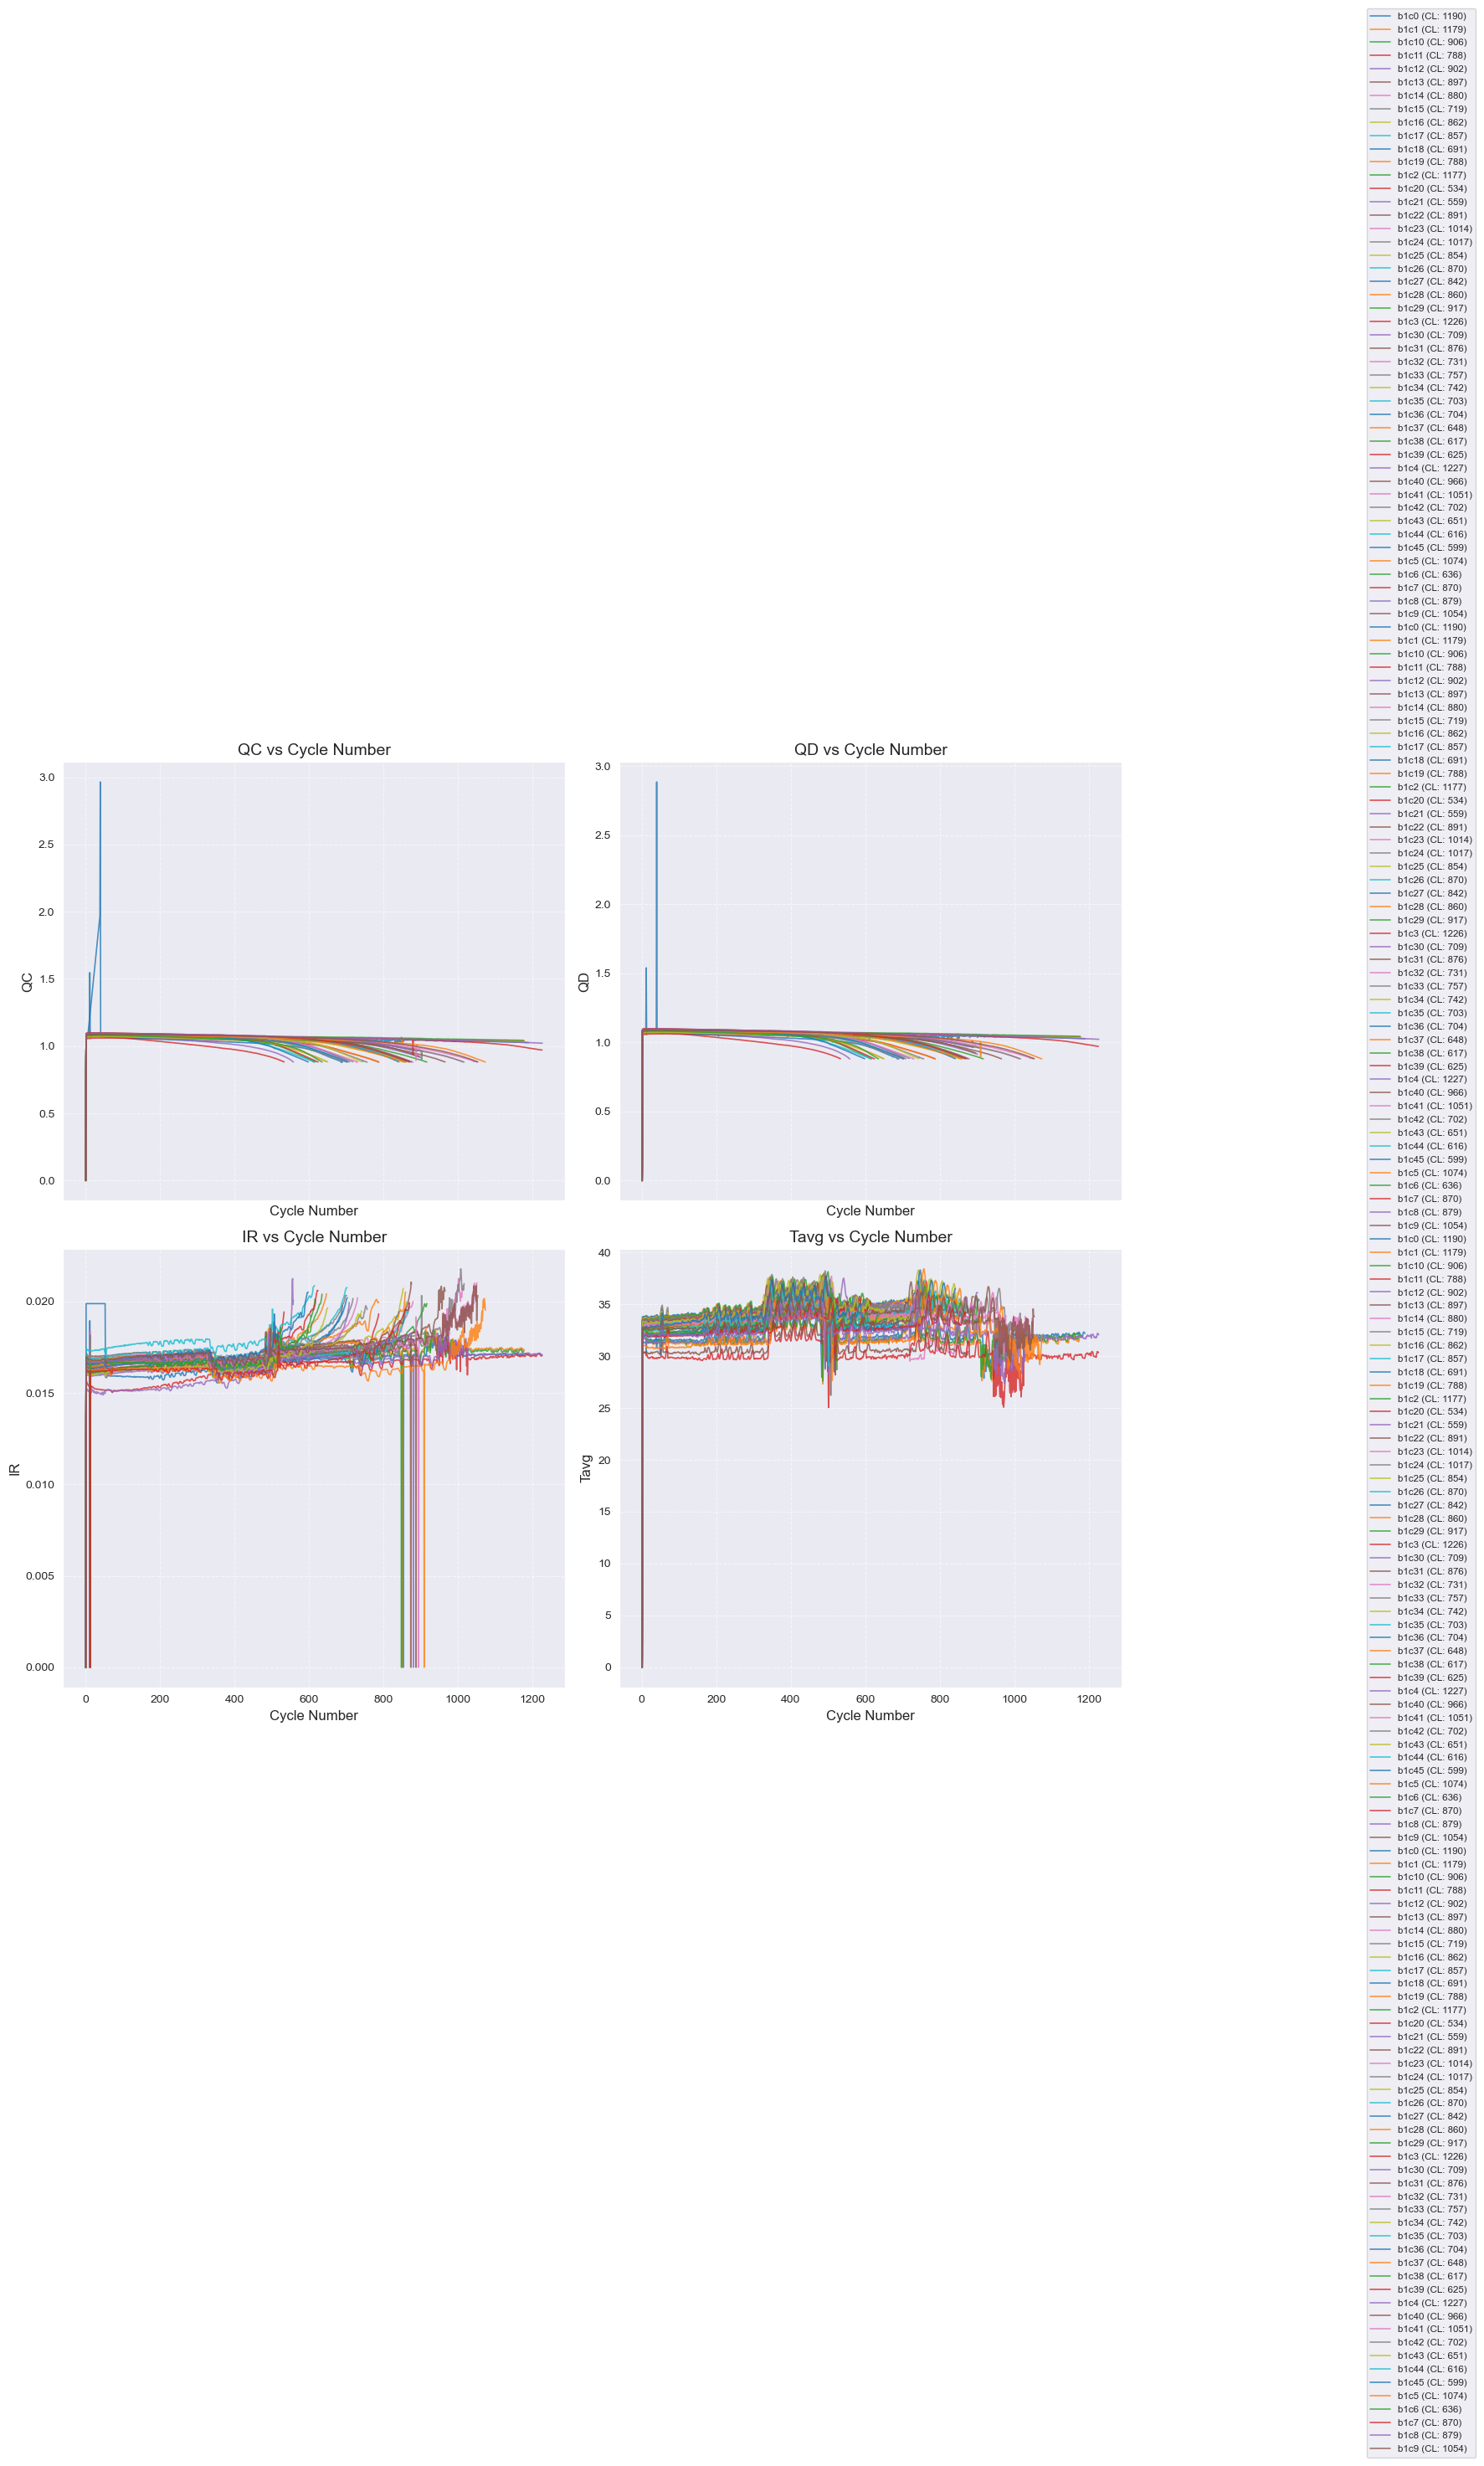

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Set up 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

# Define the features and subplot titles
plots = [
    ("QC", "QC vs Cycle Number"),
    ("QD", "QD vs Cycle Number"),
    ("IR", "IR vs Cycle Number"),
    ("Tavg", "Tavg vs Cycle Number")
]

# Loop through each feature and plot
for ax, (col, title) in zip(axes.flat, plots):
    for battery_id, group in Bt_1.groupby("battery_id"):
        group = group.sort_values(by="cycle")  # Sort by cycle
        ax.plot(
            group['cycle'],
            group[col],
            label=f"{battery_id} (CL: {group['cycle_life'].iloc[0]:.0f})",
            linewidth=1.2,
            alpha=0.8
        )
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Cycle Number", fontsize=12)
    ax.set_ylabel(col, fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.6)

# Put legend outside on the right
fig.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize="small"
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for legend
plt.show()

# batch 2

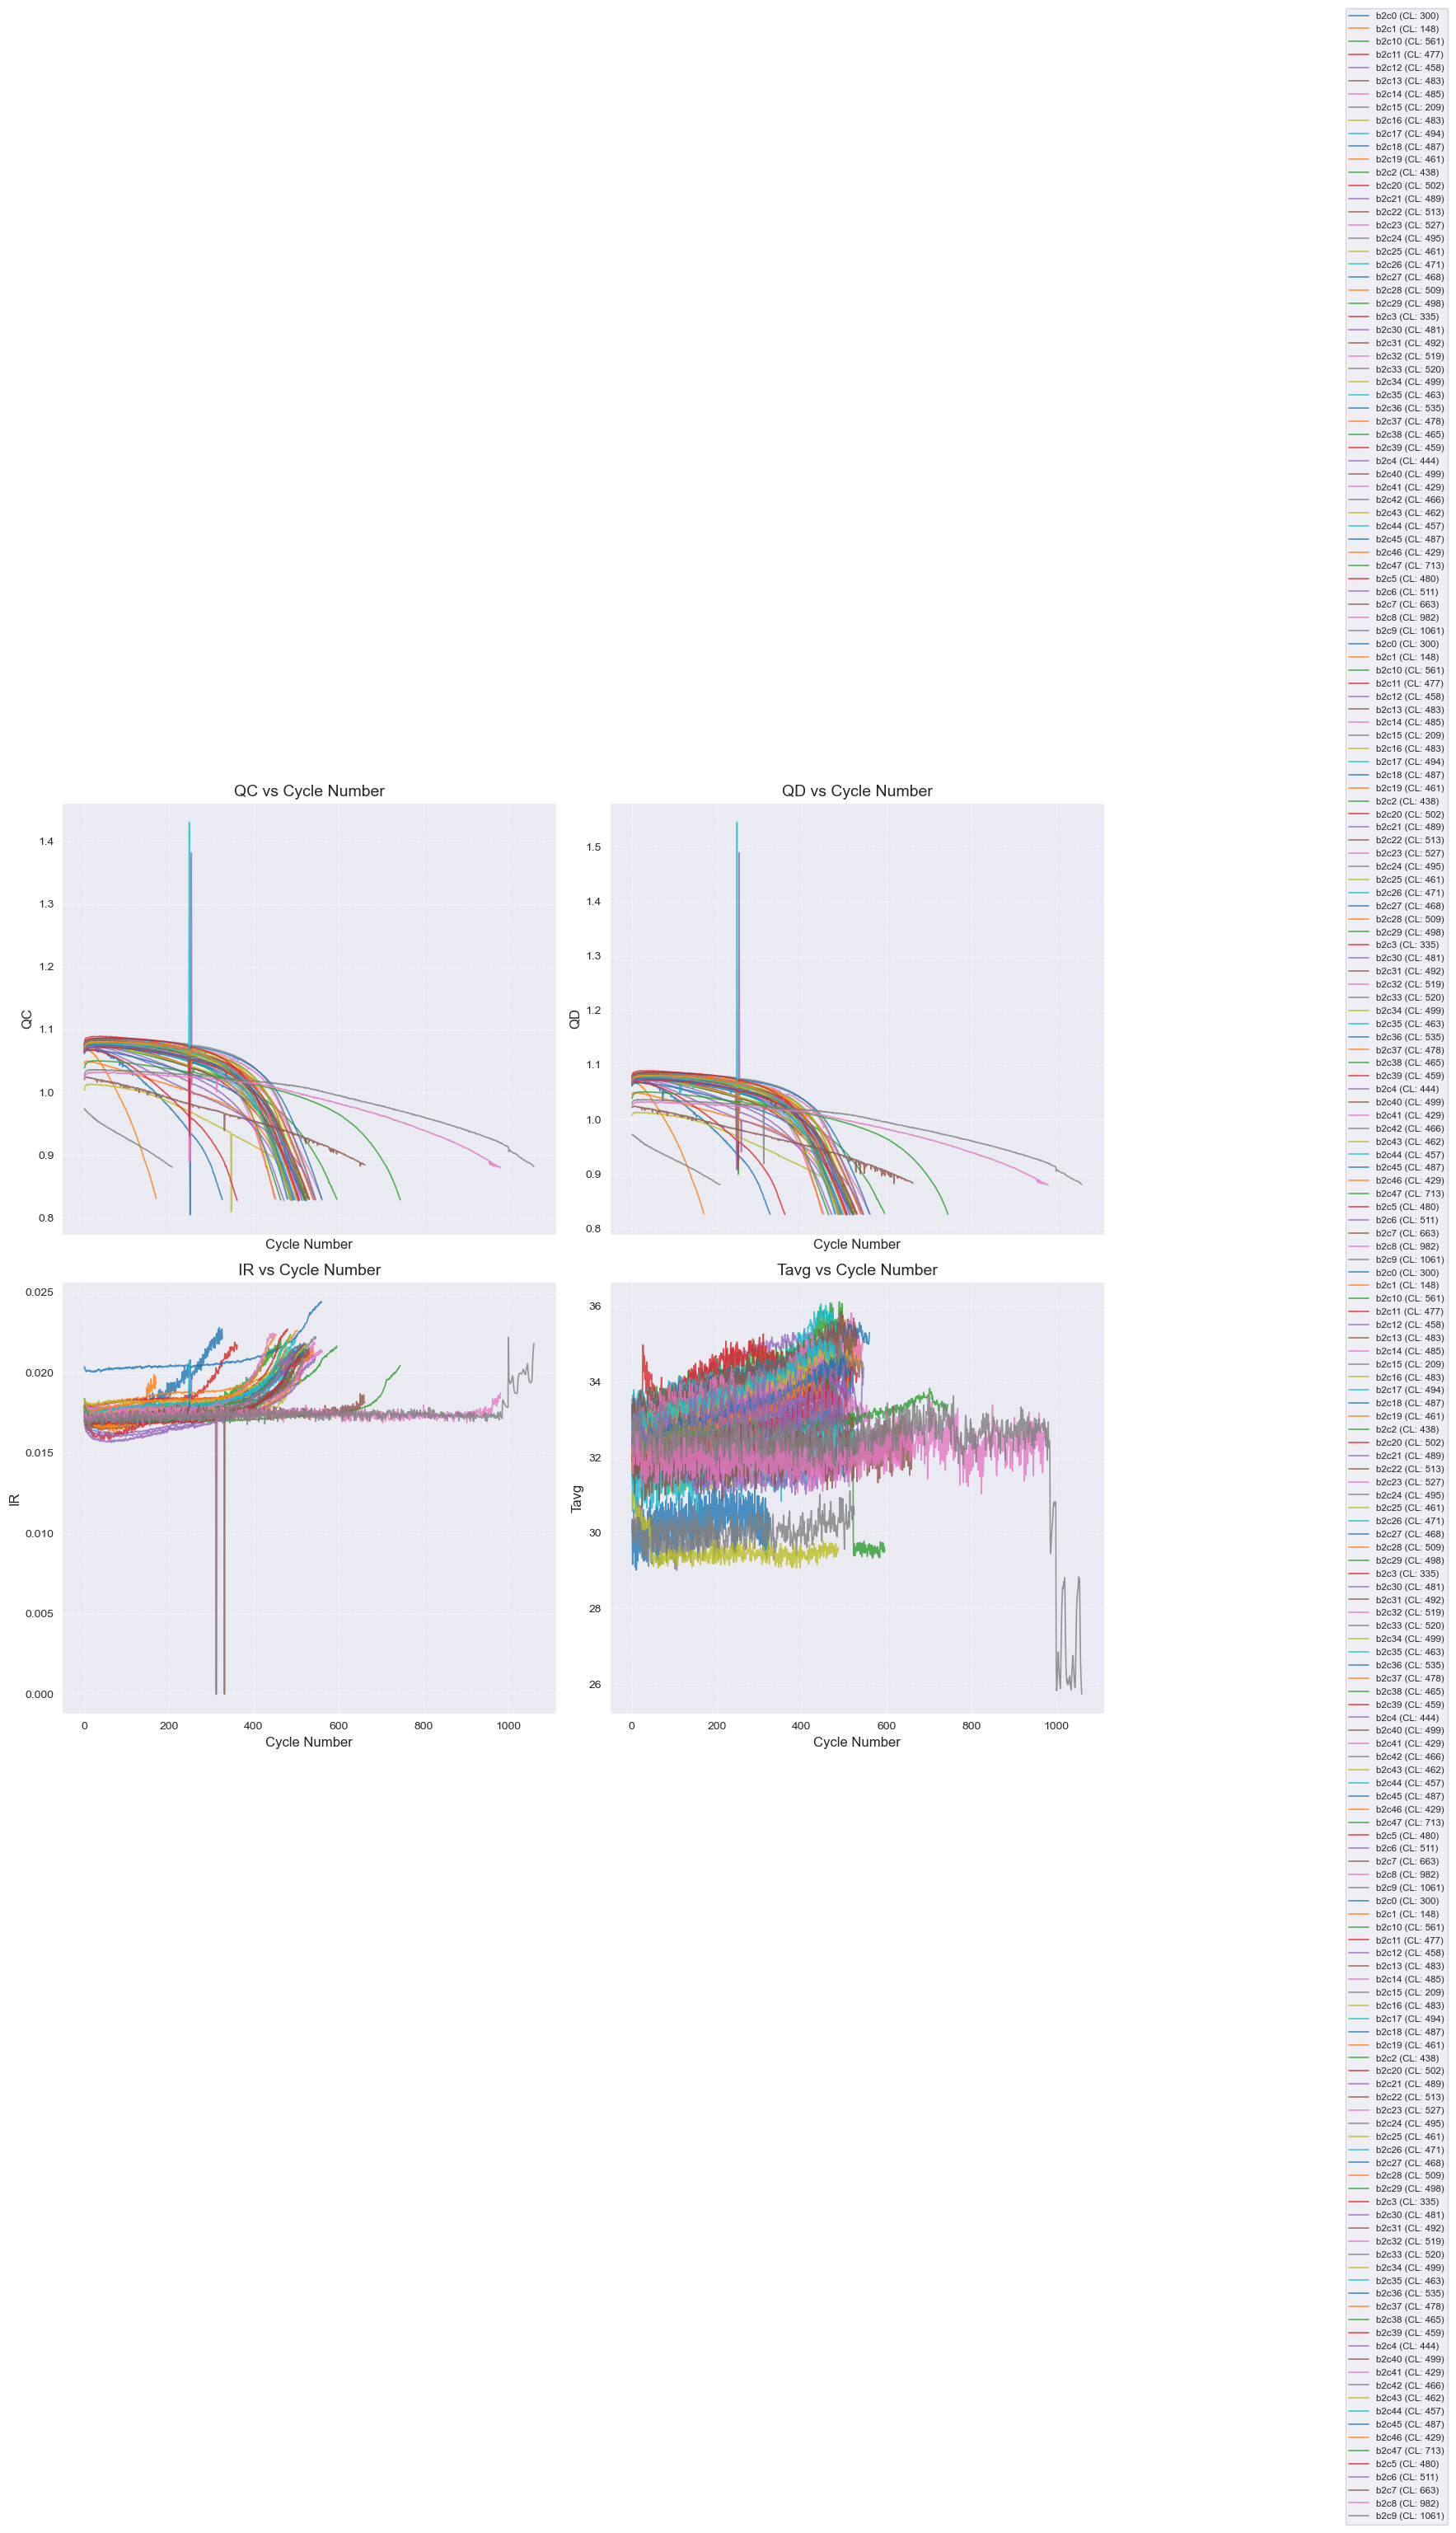

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Set up 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

# Define the features and subplot titles
plots = [
    ("QC", "QC vs Cycle Number"),
    ("QD", "QD vs Cycle Number"),
    ("IR", "IR vs Cycle Number"),
    ("Tavg", "Tavg vs Cycle Number")
]

# Loop through each feature and plot
for ax, (col, title) in zip(axes.flat, plots):
    for battery_id, group in summary_combined_2.groupby("battery_id"):
        group = group.sort_values(by="cycle")  # Sort by cycle
        ax.plot(
            group['cycle'],
            group[col],
            label=f"{battery_id} (CL: {group['cycle_life'].iloc[0]:.0f})",
            linewidth=1.2,
            alpha=0.8
        )
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Cycle Number", fontsize=12)
    ax.set_ylabel(col, fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.6)

# Put legend outside on the right
fig.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize="small"
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for legend
plt.show()

# batch 3

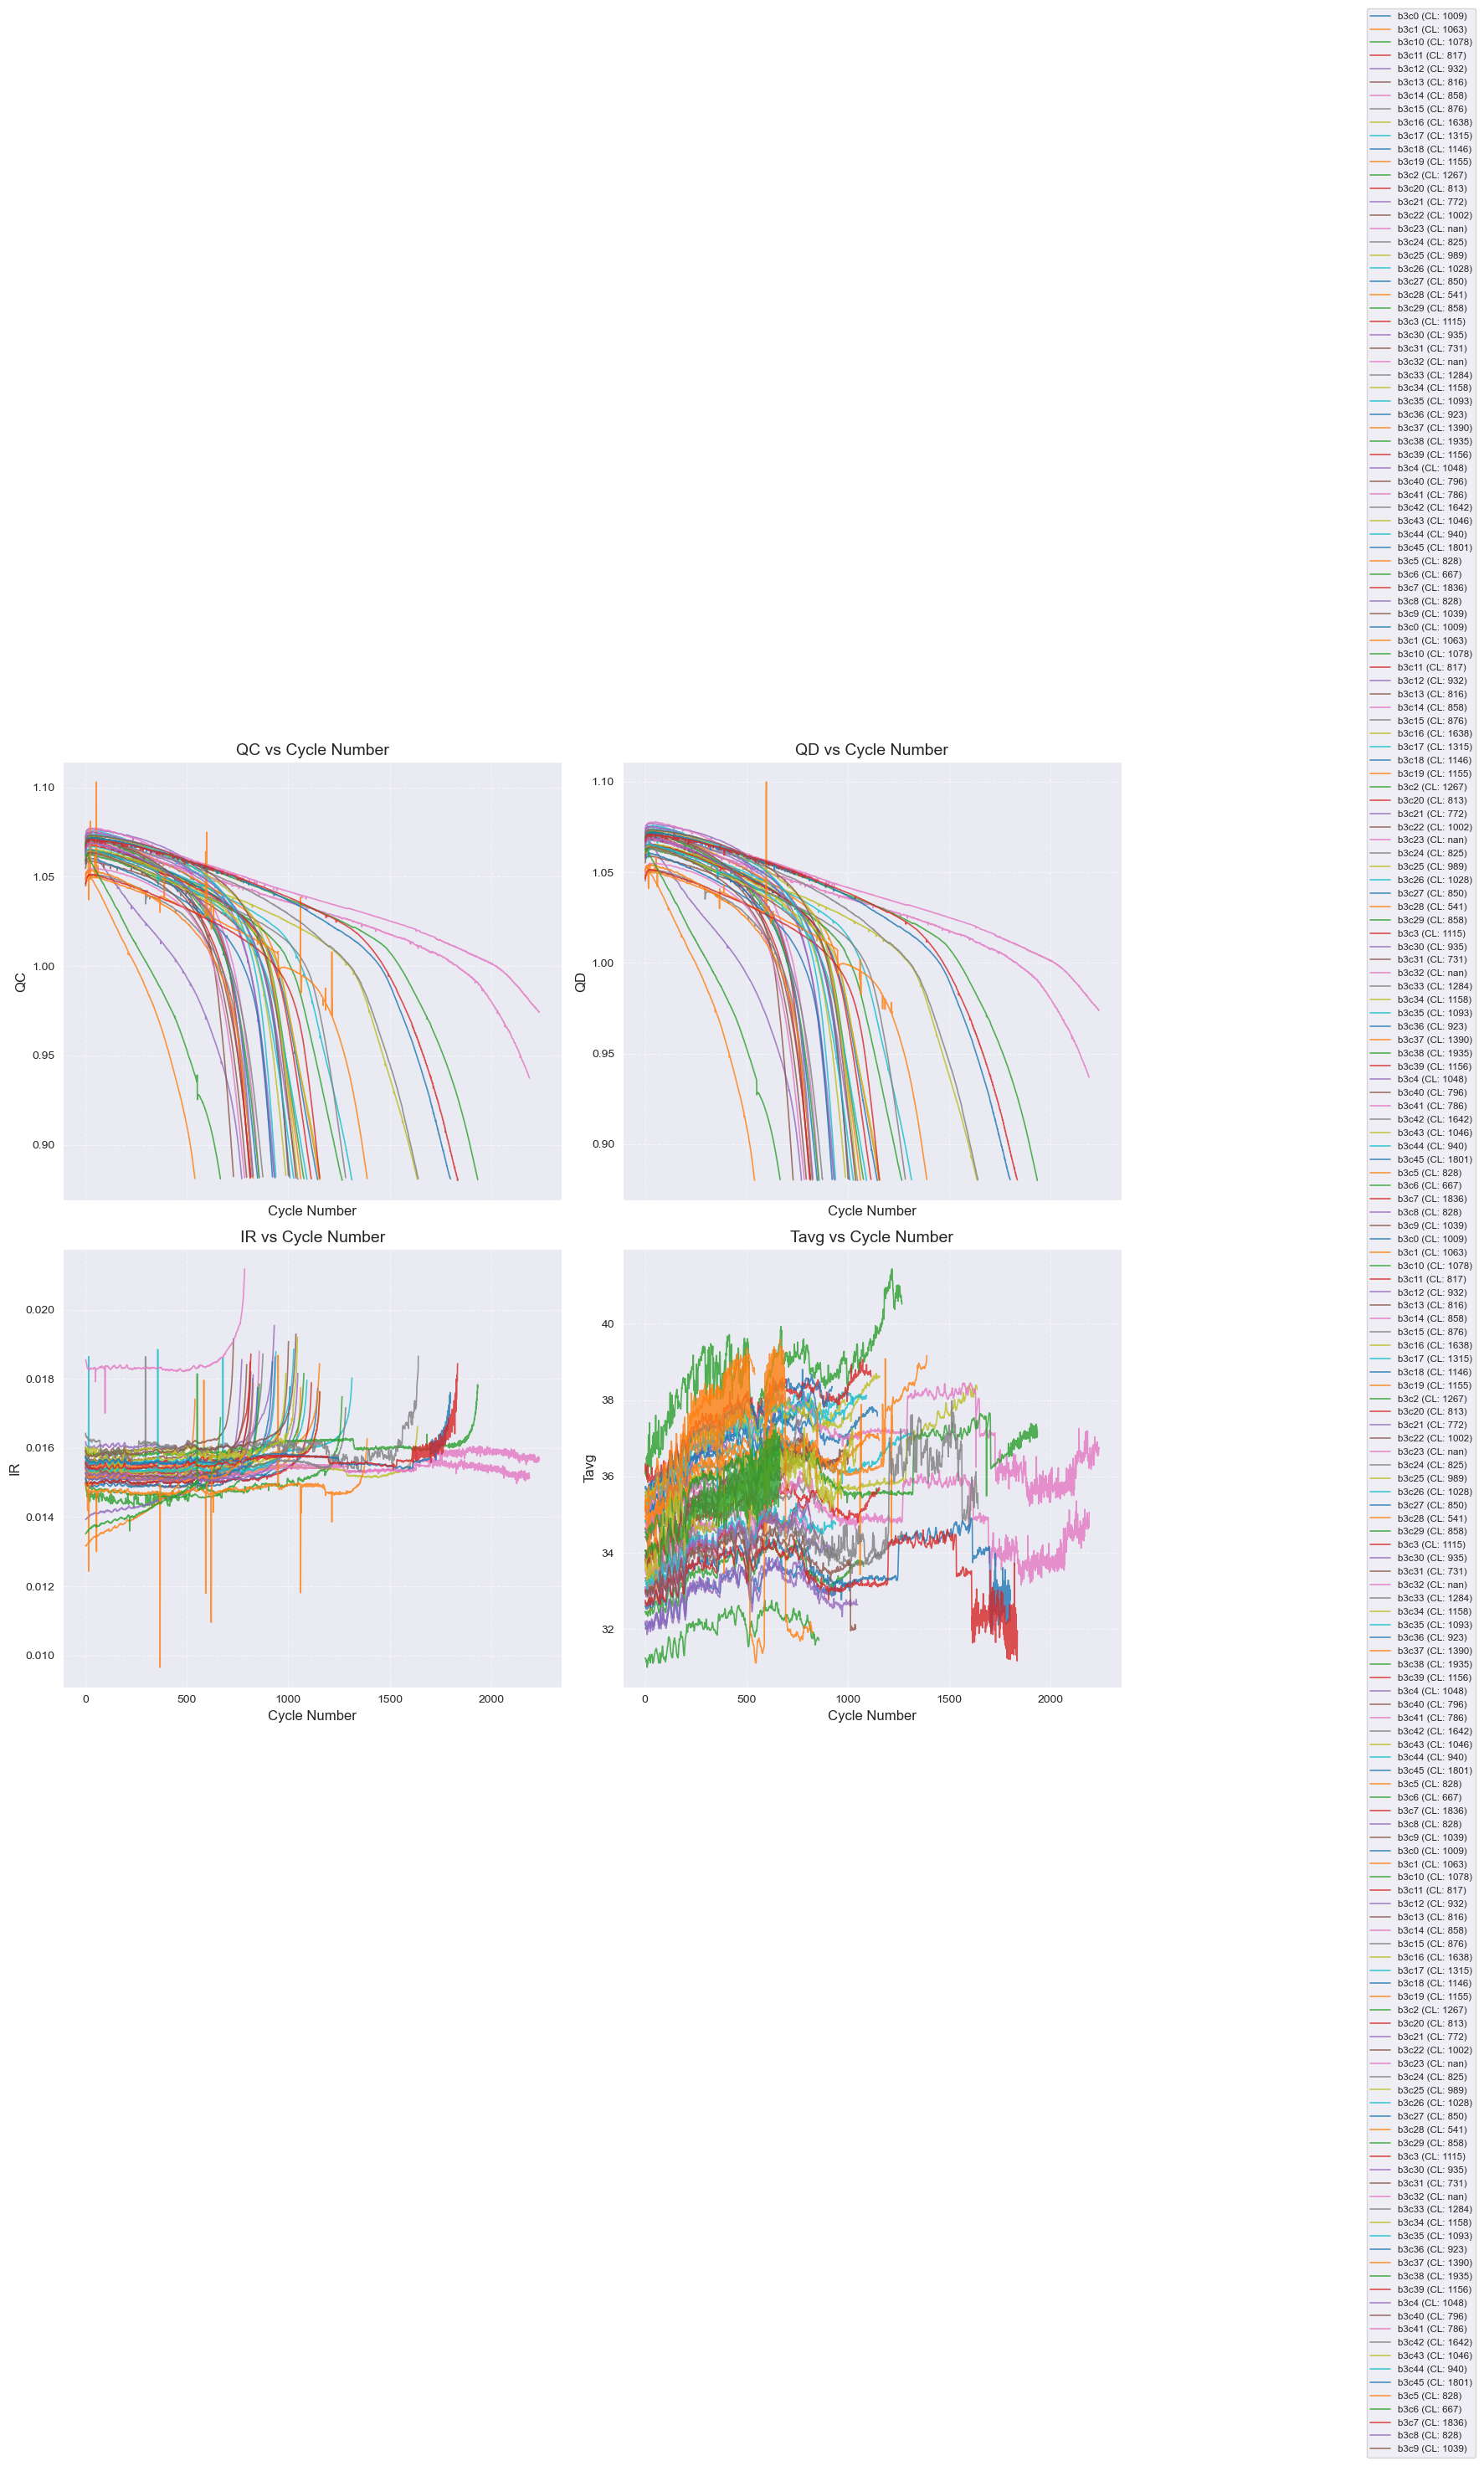

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Set up 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

# Define the features and subplot titles
plots = [
    ("QC", "QC vs Cycle Number"),
    ("QD", "QD vs Cycle Number"),
    ("IR", "IR vs Cycle Number"),
    ("Tavg", "Tavg vs Cycle Number")
]

# Loop through each feature and plot
for ax, (col, title) in zip(axes.flat, plots):
    for battery_id, group in summary_combined_3.groupby("battery_id"):
        group = group.sort_values(by="cycle")  # Sort by cycle
        ax.plot(
            group['cycle'],
            group[col],
            label=f"{battery_id} (CL: {group['cycle_life'].iloc[0]:.0f})",
            linewidth=1.2,
            alpha=0.8
        )
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Cycle Number", fontsize=12)
    ax.set_ylabel(col, fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.6)

# Put legend outside on the right
fig.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize="small"
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for legend
plt.show()


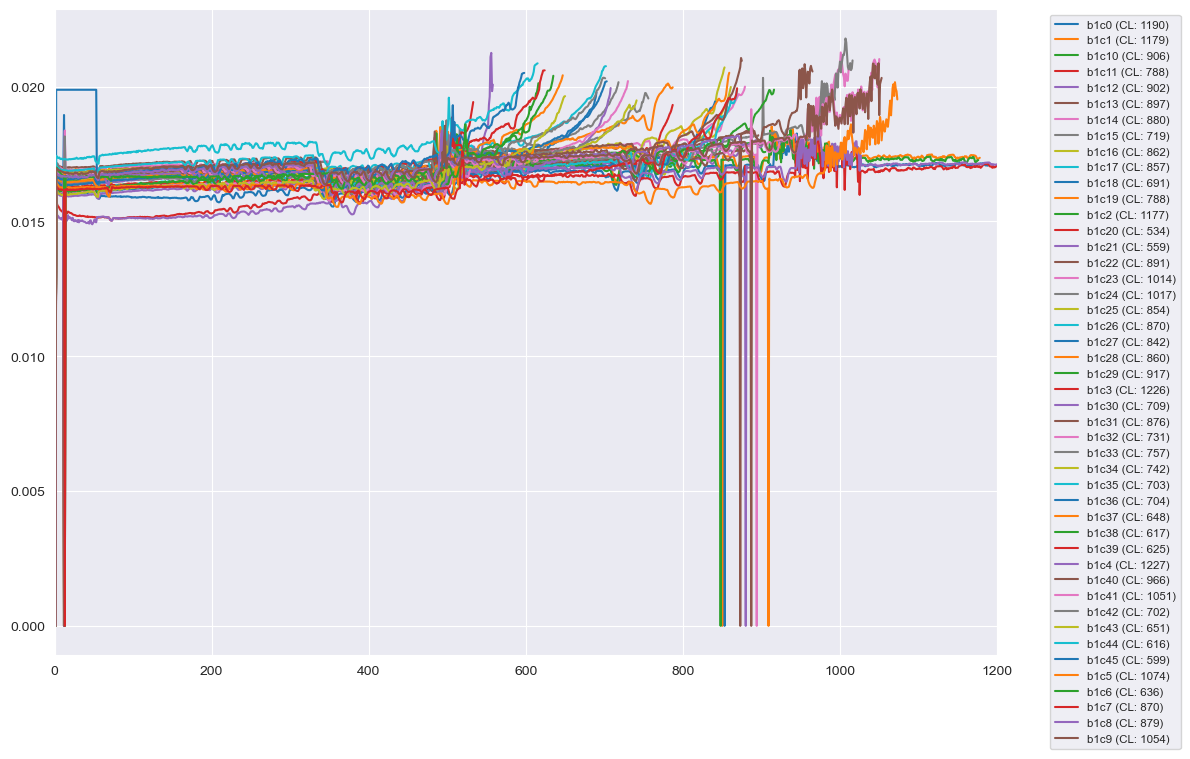

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# write batch dict
df = Bt_1

# Plot setup
plt.figure(figsize=(12, 8))

# Correct loop syntax and logic
for battery_id, group in df.groupby("battery_id"):
    group = group.sort_values(by="cycle")  # Ensure sorted by cycle
    plt.plot(
        group["cycle"],     # compareison
        group["IR"],
        label=f"{battery_id} (CL: {group['cycle_life'].iloc[0]:.0f})"
    )

# Labels and title
# plt.xlabel("Cycle Number")
# plt.ylabel("Internal Resistance (IR)")
# plt.title("IR vs Cycle Number for Each Battery")
plt.grid(True)

# Legend on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")

# Add cycle range here
plt.xlim([0, 1200])  # change 0 and 1000 to your desired cycle range

plt.tight_layout()
plt.show()
